In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy

from utils.compl_cal import compl_mul, compl_div
from utils.PINNnet import sine_init, first_layer_sine_init, PINN
from utils.plot_func import plot_field, model_pred, plot_error_field, plot_loss

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# fixed parameters
L, N = 1, 100
Lx, Ly = L, L
src = [-0.69, 0.75]
k = 2 * np.pi * 100 / 1500 * 100

In [3]:
## hyperparameter
w = 100
n_in = 2 
n_out = 2
n_hiddens = 256
n_layers = 5
n_epochs = int(1e2)
learning_rate = 2e-5

In [4]:
def loss_grad_norm(loss, model):
    loss_grad_norm = 0
    loss_clone = loss.clone()
    for params in model.parameters():
        loss_grad = torch.autograd.grad(loss_clone, params, retain_graph=True, allow_unused=True, materialize_grads=True)[0]
        loss_grad_norm += torch.sum(loss_grad**2)
    loss_grad_norm = loss_grad_norm**0.5
    loss_grad_norm = loss_grad_norm.detach()
    return loss_grad_norm

def update_lambda(model, loss_lst, lamb_lst, alpha):
    grad = []
    for loss in loss_lst:
        grad.append(loss_grad_norm(loss, model))
    grad_sum = sum(grad)
    lamb = []
    for i in range(len(grad)):
        lamb_hat = grad_sum / grad[i]
        if torch.isnan(lamb_hat) or torch.isinf(lamb_hat):
            lamb_hat = torch.ones_like(lamb_hat)
        lamb_new = alpha*lamb_lst[i] + (1-alpha)*lamb_hat
        lamb.append(lamb_new)
    return lamb

In [19]:
## Dataset
def green(x, y, src, device=device, is_tensor='True'):
    if is_tensor:
        r = torch.sqrt((x-src[0]) ** 2 + (y-src[1]) ** 2)
        r = r.detach().to('cpu').numpy()
        hankel = scipy.special.hankel2(0, k * r + 1e-6)
        g = 0.25j * hankel
        g_real, g_imag = g.real, g.imag
        g_real, g_imag = torch.tensor(g_real, dtype=torch.float32), torch.tensor(g_imag, dtype=torch.float32)
        g = torch.cat([g_real, g_imag], dim=-1).to(device)
    else:
        r = np.sqrt((x-src[0]) ** 2 + (y-src[1]) ** 2)
        hankel = scipy.special.hankel2(0, k * r + 1e-6)
        g = 0.25j * hankel
        g_real, g_imag = g.real, g.imag
        g = np.concatenate([g_real, g_imag], axis=-1)
    return g

def get_dataset(Lx, Ly, src, std=0.01, device=device):
    # pde
    x0, y0 = 2 * Lx * torch.rand(100000, 1) - Lx, 2 * Ly * torch.rand(100000, 1) - Ly
    r, theta = torch.linspace(0, 2.5, 500), torch.linspace(0, 2 * np.pi, 360)
    r, theta = torch.meshgrid(r, theta)
    r, theta = r.reshape(-1, 1), theta.reshape(-1, 1)
    x, y = r * torch.cos(theta) + src[0], r * torch.sin(theta) + src[1]
    x_min, x_max = -Lx, Lx
    y_min, y_max = -Ly, Ly
    mask = (x >= x_min) & (x <= x_max) & (y >= y_min) & (y <= y_max)
    x, y = x[mask].reshape(-1, 1), y[mask].reshape(-1, 1)
    x0, y0 = x[-len(r):, :], y[-len(r):, :]
    f = 1 / (2 * np.pi * std ** 2) * torch.exp(-0.5 * (((x0 - src[0])/std)**2 + ((y0 - src[1])/std)**2))
    f = torch.cat([f, torch.zeros_like(f)], dim=-1)

    # supervise
    x, y = -0.5 * torch.ones(100), torch.linspace(-0.5, 0, 100)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    p = green(x, y, src) - green(x, y, [-0.69, 1.25])
    return torch.tensor(x0, dtype=torch.float32, requires_grad=False).to(device),\
            torch.tensor(y0, dtype=torch.float32, requires_grad=False).to(device),\
            f.to(device),\
            torch.tensor(x, dtype=torch.float32, requires_grad=False).to(device),\
            torch.tensor(y, dtype=torch.float32, requires_grad=False).to(device),\
            p.to(device)

def data_iter(batch_size, x, y, f):
    import random as rd
    num = len(f)
    ids = list(range(num))
    rd.shuffle(ids)
    for i in range(0, num, batch_size):
        batch_id = torch.tensor(ids[i:min(i + batch_size, num)])
        yield x[batch_id], y[batch_id], f[batch_id]

In [20]:
def get_PML_coefficient(x, y, L_pml, sigma0):
    dist_hor = torch.clamp(torch.abs(x) - (Lx - L_pml), min=0)
    dist_ver = torch.clamp(- y - (Lx - L_pml), min=0)
    sx = sigma0 * (dist_hor / L_pml) ** 2
    sy = sigma0 * (dist_ver / L_pml) ** 2
    ex = torch.cat([torch.ones_like(sx), -sx], dim=-1)
    ey = torch.cat([torch.ones_like(sy), -sy], dim=-1)
    return ex, ey

def loss_fn(model, x, y, src, k, f, L_pml=0.3, sigma0=5):
    x, y = x.reshape(-1, 1).to(device), y.reshape(-1, 1).to(device)
    x, y = x.requires_grad_(), y.requires_grad_()
    ex, ey = get_PML_coefficient(x, y, L_pml, sigma0)
    xy = torch.cat([x, y], dim=-1)
    p = model(xy)
    px_real = torch.autograd.grad(p[:, 0:1], x, torch.ones_like(p[:, 0:1]), create_graph=True)[0]
    px_imag = torch.autograd.grad(p[:, 1:2], x, torch.ones_like(p[:, 1:2]), create_graph=True)[0]
    px = compl_mul(compl_div(ey, ex), torch.cat([px_real, px_imag], dim=-1))
    pxx_real = torch.autograd.grad(px[:, 0:1], x, torch.ones_like(px[:, 0:1]), create_graph=True)[0]
    pxx_imag = torch.autograd.grad(px[:, 1:2], x, torch.ones_like(px[:, 1:2]), create_graph=True)[0]
    pxx = torch.cat([pxx_real, pxx_imag], dim=-1)
    py_real = torch.autograd.grad(p[:, 0:1], y, torch.ones_like(p[:, 0:1]), create_graph=True)[0]
    py_imag = torch.autograd.grad(p[:, 1:2], y, torch.ones_like(p[:, 1:2]), create_graph=True)[0]
    py = compl_mul(compl_div(ex, ey), torch.cat([py_real, py_imag], dim=-1))
    pyy_real = torch.autograd.grad(py[:, 0:1], y, torch.ones_like(py[:, 0:1]), create_graph=True)[0]
    pyy_imag = torch.autograd.grad(py[:, 1:2], y, torch.ones_like(py[:, 1:2]), create_graph=True)[0]
    pyy = torch.cat([pyy_real, pyy_imag], dim=-1)
    
    res = pxx + pyy + k**2 * compl_mul(compl_mul(ex, ey), p) - f
    del pyy, pxx
    return (res ** 2).mean()

def loss_bd(model, Lx, Ly, device=device):
    x, y = torch.linspace(-Lx, Lx, 500), torch.ones(500)
    #y[:int(y.shape[0] / 2)] = -y[:int(x.shape[0] / 2)]
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    x = torch.tensor(x, dtype=torch.float32, requires_grad=True).to(device)
    y = torch.tensor(y, dtype=torch.float32, requires_grad=True).to(device)
    xy = torch.cat([x, y], dim=-1)
    p = model(xy)
    return (p ** 2).mean()

In [21]:
new_train = False
if new_train:
    model = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
    model.apply(sine_init)
    model.net[0].apply(first_layer_sine_init)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    lamb = [1, 1]
    l_lst = []
    n_lamb_update = 50
else:
    import joblib
    state_dict = joblib.load('model_supervise.joblib')
    model = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
    model.load_state_dict(state_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    lamb = [1, 1, 1]
    l_lst = []
    n_lamb_update = 50

In [30]:
n_epochs = int(2e2)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-6)

In [ ]:
x0, y0, f0, x_s, y_s, p_s = get_dataset(Lx, Ly, src)
i = 0
loss_min = 2
model = model.to(device)
for epoch in tqdm(range(n_epochs)):
    for x, y, f in data_iter(10000, x0, y0, f0):
        optimizer.zero_grad()
        loss_pde = loss_fn(model, x, y, src, k, f, L_pml=0.3, sigma0=5)
        loss_bound = loss_bd(model, Lx, Ly)
        loss_data = ((model(torch.cat([x_s, y_s], dim=-1)) - p_s) ** 2).mean()
        if i % 50 == 0:
            loss_lst = [loss_pde, loss_bound, loss_data]
            lamb = update_lambda(model, loss_lst, lamb, 0.9)
        loss = loss_pde + loss_bound * lamb[1] / lamb[0] + loss_data * lamb[2] / lamb[0]
        loss.backward()
        optimizer.step()
        i = i + 1
    
    if (epoch + 1) % 5 == 0: 
        print(f'Epoch {epoch+1}, Loss: {loss.item():.5f}, Loss_pde: {loss_pde.item():.5f}, Loss_bound: {loss_bound.item():.5f}')
    if loss_min > loss.item():
        loss_min = loss.item()
        model0 = model
    l_lst.append(loss)

/tmp/ipykernel_20416/3445564173.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x0, dtype=torch.float32, requires_grad=False).to(device),\
/tmp/ipykernel_20416/3445564173.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y0, dtype=torch.float32, requires_grad=False).to(device),\
/tmp/ipykernel_20416/3445564173.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(x, dtype=torch.float32, requires_grad=False).to(device),\
/tmp/ipykernel_20416/3445564173.py:42: UserWarning: To copy constru

Epoch 5, Loss: 4.03214, Loss_pde: 3.66127, Loss_bound: 0.00000


  5%|▌         | 10/200 [00:11<03:40,  1.16s/it]

Epoch 10, Loss: 0.66903, Loss_pde: 0.64199, Loss_bound: 0.00000


  8%|▊         | 15/200 [00:17<03:54,  1.27s/it]

Epoch 15, Loss: 0.55570, Loss_pde: 0.54748, Loss_bound: 0.00000


 10%|█         | 20/200 [00:23<03:17,  1.10s/it]

Epoch 20, Loss: 0.51669, Loss_pde: 0.51022, Loss_bound: 0.00000


 12%|█▎        | 25/200 [00:29<03:18,  1.14s/it]

Epoch 25, Loss: 0.52085, Loss_pde: 0.51500, Loss_bound: 0.00000


 15%|█▌        | 30/200 [00:35<03:25,  1.21s/it]

Epoch 30, Loss: 0.45197, Loss_pde: 0.44667, Loss_bound: 0.00000


 18%|█▊        | 35/200 [00:40<03:00,  1.09s/it]

Epoch 35, Loss: 0.41266, Loss_pde: 0.40759, Loss_bound: 0.00000


 20%|██        | 40/200 [00:46<02:59,  1.12s/it]

Epoch 40, Loss: 0.39760, Loss_pde: 0.39249, Loss_bound: 0.00000


 22%|██▎       | 45/200 [00:51<02:52,  1.11s/it]

Epoch 45, Loss: 0.41721, Loss_pde: 0.41277, Loss_bound: 0.00000


 25%|██▌       | 50/200 [00:57<02:42,  1.08s/it]

Epoch 50, Loss: 0.39602, Loss_pde: 0.39186, Loss_bound: 0.00000


 28%|██▊       | 55/200 [01:03<02:42,  1.12s/it]

Epoch 55, Loss: 0.36160, Loss_pde: 0.35757, Loss_bound: 0.00000


 30%|███       | 60/200 [01:09<02:44,  1.18s/it]

Epoch 60, Loss: 0.35459, Loss_pde: 0.34919, Loss_bound: 0.00000


 32%|███▎      | 65/200 [01:15<02:53,  1.28s/it]

Epoch 65, Loss: 0.34136, Loss_pde: 0.33801, Loss_bound: 0.00000


 35%|███▌      | 70/200 [01:20<02:24,  1.11s/it]

Epoch 70, Loss: 0.33771, Loss_pde: 0.32867, Loss_bound: 0.00000


 38%|███▊      | 75/200 [01:26<02:23,  1.15s/it]

Epoch 75, Loss: 0.31057, Loss_pde: 0.30548, Loss_bound: 0.00000


 40%|████      | 80/200 [01:32<02:26,  1.22s/it]

Epoch 80, Loss: 0.43944, Loss_pde: 0.32378, Loss_bound: 0.00000


 42%|████▎     | 85/200 [01:38<02:06,  1.10s/it]

Epoch 85, Loss: 0.29547, Loss_pde: 0.29216, Loss_bound: 0.00000


 45%|████▌     | 90/200 [01:44<02:04,  1.13s/it]

Epoch 90, Loss: 0.27621, Loss_pde: 0.27068, Loss_bound: 0.00000


 48%|████▊     | 95/200 [01:49<01:57,  1.12s/it]

Epoch 95, Loss: 0.29728, Loss_pde: 0.29445, Loss_bound: 0.00000


 50%|█████     | 100/200 [01:55<01:48,  1.09s/it]

Epoch 100, Loss: 0.28947, Loss_pde: 0.26384, Loss_bound: 0.00000


 52%|█████▎    | 105/200 [02:01<01:47,  1.13s/it]

Epoch 105, Loss: 0.29725, Loss_pde: 0.28685, Loss_bound: 0.00000


 55%|█████▌    | 110/200 [02:07<01:46,  1.18s/it]

Epoch 110, Loss: 0.26837, Loss_pde: 0.26596, Loss_bound: 0.00000


 57%|█████▊    | 115/200 [02:13<01:49,  1.29s/it]

Epoch 115, Loss: 0.25738, Loss_pde: 0.25436, Loss_bound: 0.00000


 60%|██████    | 120/200 [02:18<01:29,  1.12s/it]

Epoch 120, Loss: 0.26275, Loss_pde: 0.25527, Loss_bound: 0.00000


 62%|██████▎   | 125/200 [02:24<01:26,  1.15s/it]

Epoch 125, Loss: 0.24455, Loss_pde: 0.23813, Loss_bound: 0.00000


 65%|██████▌   | 130/200 [02:30<01:25,  1.23s/it]

Epoch 130, Loss: 0.24135, Loss_pde: 0.23177, Loss_bound: 0.00000


 68%|██████▊   | 135/200 [02:36<01:12,  1.11s/it]

Epoch 135, Loss: 0.24603, Loss_pde: 0.23910, Loss_bound: 0.00000


 70%|███████   | 140/200 [02:42<01:07,  1.13s/it]

Epoch 140, Loss: 0.22690, Loss_pde: 0.22400, Loss_bound: 0.00000


 72%|███████▎  | 145/200 [02:47<01:01,  1.13s/it]

Epoch 145, Loss: 0.21309, Loss_pde: 0.21082, Loss_bound: 0.00000


 75%|███████▌  | 150/200 [02:53<00:54,  1.09s/it]

Epoch 150, Loss: 0.34127, Loss_pde: 0.23572, Loss_bound: 0.00000


 78%|███████▊  | 155/200 [02:59<00:50,  1.13s/it]

Epoch 155, Loss: 0.20308, Loss_pde: 0.20082, Loss_bound: 0.00000


 80%|████████  | 160/200 [03:05<00:47,  1.18s/it]

Epoch 160, Loss: 0.22221, Loss_pde: 0.21128, Loss_bound: 0.00000


 82%|████████▎ | 165/200 [03:11<00:45,  1.29s/it]

Epoch 165, Loss: 0.21644, Loss_pde: 0.20694, Loss_bound: 0.00000


 85%|████████▌ | 170/200 [03:16<00:33,  1.12s/it]

Epoch 170, Loss: 0.22260, Loss_pde: 0.21397, Loss_bound: 0.00000


 88%|████████▊ | 175/200 [03:23<00:28,  1.15s/it]

Epoch 175, Loss: 0.28963, Loss_pde: 0.21924, Loss_bound: 0.00000


 90%|█████████ | 180/200 [03:29<00:24,  1.23s/it]

Epoch 180, Loss: 20.24289, Loss_pde: 1.92279, Loss_bound: 0.00000


 92%|█████████▎| 185/200 [03:34<00:16,  1.11s/it]

Epoch 185, Loss: 0.48772, Loss_pde: 0.36823, Loss_bound: 0.00000


 94%|█████████▍| 189/200 [03:39<00:12,  1.16s/it]

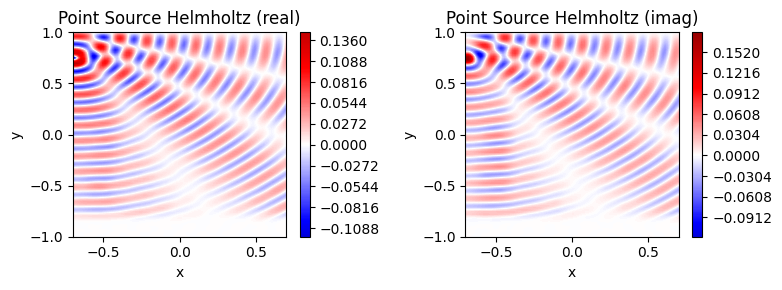

In [24]:
model_pred(model, 0.7, 1, bar_max=0.2)

In [10]:
import joblib
joblib.dump(model.state_dict(), 'model_supervise.joblib')

['model_batches.joblib']

In [25]:
loss_min

0.18207503855228424

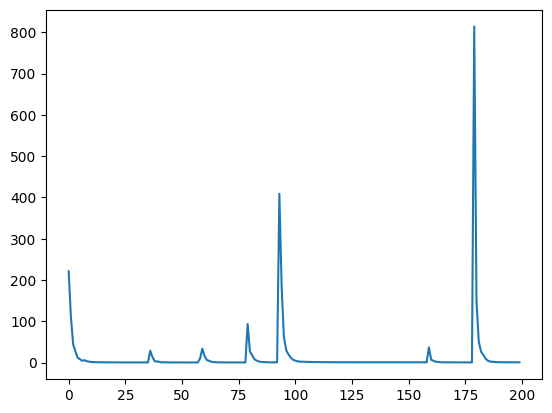

In [26]:
plot_loss(l_lst)

In [27]:
def abs_field(model, Lx, Ly, N=100):
    x, y = torch.linspace(-Lx, Lx, N), torch.linspace(-Ly, Ly, N)
    x, y = torch.meshgrid(x, y)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    model = model.to('cpu')
    inputs = torch.cat([x, y], dim=-1)
    p_real = model(inputs)[:, 0].detach().numpy()
    p_imag = model(inputs)[:, 1].detach().numpy()
    p_real, p_imag = p_real.reshape(N, N), p_imag.reshape(N, N)
    p = p_real ** 2 + p_imag ** 2

    plt.figure(figsize=(4, 3))
    p_max = np.max(np.abs(p))
    cmap = matplotlib.cm.seismic
    norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
    plt.contourf(x.reshape(N, N), y.reshape(N, N), p, levels=400, cmap=cmap, origin='lower', norm=norm)
    plt.colorbar()
    plt.title('Point Source Helmholtz (real)')
    plt.xlabel('x')
    plt.ylabel('y')

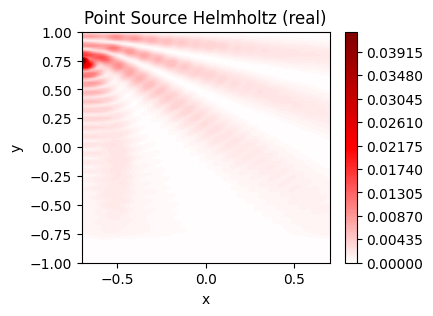

In [28]:
abs_field(model, 0.7, Ly)

Error(Real) -0.10312210023403168, Error(Imag) 0.584011971950531


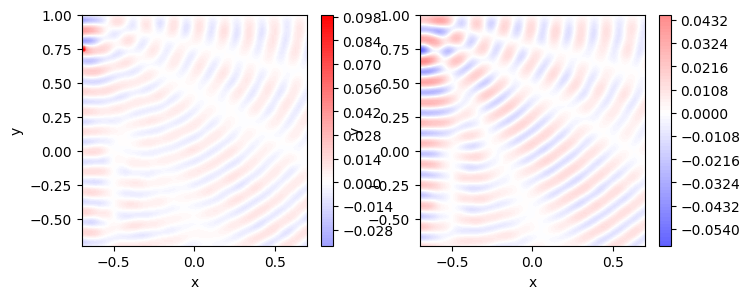

In [29]:
x, y = torch.linspace(-0.7, 0.7, N), torch.linspace(-0.7, 1, N)
x, y = torch.meshgrid(x, y)
x, y = x.reshape(-1, 1), y.reshape(-1, 1)
model = model.to('cpu')
inputs = torch.cat([x, y], dim=-1)
p_real = model(inputs)[:, 0].detach().numpy()
p_imag = model(inputs)[:, 1].detach().numpy()
p_real, p_imag = p_real.reshape(N, N), p_imag.reshape(N, N)

x, y = x.numpy(), y.numpy()
#hankel = scipy.special.hankel2(0, k * np.sqrt((x+0.69) ** 2 + (y-0.75) ** 2) + 1e-6) -\
    #scipy.special.hankel2(0, k * np.sqrt((x+0.69) ** 2 + (y-1.25) ** 2) + 1e-6)
#p_ref = 0.25j * hankel
p_ref = green(x, y, src, is_tensor=False) - green(x, y, [-0.69, 1.25], is_tensor=False)
p_ref_real, p_ref_imag = p_ref[:, 0:1].reshape(N, N), p_ref[:, 1:2].reshape(N, N)

error_real = p_real - p_ref_real
error_imag = p_imag - p_ref_imag

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
p_max = 0.2
cmap = matplotlib.cm.seismic
norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
plt.contourf(x.reshape(N, N), y.reshape(N, N), error_real, levels=400, cmap=cmap, origin='lower', norm=norm)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 2, 2)
p_max = 0.2
cmap = matplotlib.cm.seismic
norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
plt.contourf(x.reshape(N, N), y.reshape(N, N), error_imag, levels=400, cmap=cmap, origin='lower', norm=norm)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
print(f"Error(Real) {error_real.mean() / p_ref_real.mean()}, Error(Imag) {error_imag.mean() / p_ref_imag.mean()}")

In [18]:
p_s

tensor([[ 0.0407,  0.0407],
        [ 0.0380,  0.0380],
        [ 0.0336,  0.0336],
        [ 0.0278,  0.0278],
        [ 0.0208,  0.0208],
        [ 0.0128,  0.0128],
        [ 0.0042,  0.0042],
        [-0.0046, -0.0046],
        [-0.0132, -0.0132],
        [-0.0212, -0.0212],
        [-0.0283, -0.0283],
        [-0.0343, -0.0343],
        [-0.0387, -0.0387],
        [-0.0415, -0.0415],
        [-0.0424, -0.0424],
        [-0.0415, -0.0415],
        [-0.0388, -0.0388],
        [-0.0344, -0.0344],
        [-0.0284, -0.0284],
        [-0.0213, -0.0213],
        [-0.0131, -0.0131],
        [-0.0044, -0.0044],
        [ 0.0045,  0.0045],
        [ 0.0133,  0.0133],
        [ 0.0215,  0.0215],
        [ 0.0288,  0.0288],
        [ 0.0349,  0.0349],
        [ 0.0394,  0.0394],
        [ 0.0423,  0.0423],
        [ 0.0433,  0.0433],
        [ 0.0424,  0.0424],
        [ 0.0397,  0.0397],
        [ 0.0352,  0.0352],
        [ 0.0292,  0.0292],
        [ 0.0220,  0.0220],
        [ 0.0137,  0